## Python for Finance 10 - Stock Market Predictions

In [18]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data as web # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import datetime as dt # For defining dates
import mplfinance as mpf # Matplotlib finance

import time

# Used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

#Statsmodels is a great library we can use to run regressions.
import statsmodels.api as sm
# Seaborn extends the capabilities of Matplotlib
import seaborn as sns
# Used for calculating regressions
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

#### Dates & Other Constants

In [19]:
# Define path to files
# For Windows
PATH = "../data/stock-list/"

# Start date defaults
ST_YEAR = 2017
ST_MONTH = 1
ST_DAY = 1
ST_DATE_STR = f"{ST_YEAR}-{ST_MONTH}-{ST_DAY}"
ST_DATE_DATETIME = dt.datetime(ST_YEAR, ST_MONTH, ST_DAY)

# End date defaults
EN_YEAR = 2021
EN_MONTH = 12
EN_DAY = 31
EN_DATE_STR = f"{EN_YEAR}-{EN_MONTH}-{EN_DAY}"
EN_DATE_DATETIME = dt.datetime(EN_YEAR, EN_MONTH, EN_DAY)

risk_free_rate = 0.0125 # Approximate 10 year bond rate

#### Function that Saves Dataframe to CSV

In [20]:
def save_dataframe_to_csv(df, ticker):
    df.to_csv(PATH + ticker + '.csv')

#### Function that Returns a Dataframe from a CSV

In [21]:
def get_df_from_csv(ticker):
    try:
        df = pd.read_csv(PATH + ticker + '.csv', index_col='Date', 
                         parse_dates=True)
    except FileNotFoundError:
        pass
        # print("File Doesn't Exist")
    else:
        return df

#### Add Daily Return to Dataframe

In [22]:
# Shift provides the value from the previous day
# NaN is displayed because there was no previous day price for the 1st calculation
def add_daily_return_to_df(df, ticker):
    df['daily_return'] = (df['Adj Close'] / df['Adj Close'].shift(1)) - 1
    # Save data to a CSV file
    save_dataframe_to_csv(df, ticker)
    return df

#### Merge Multiple Stocks in One Dataframe by Column Name

In [23]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
    # Will hold data for all dataframes with the same column name
    mult_df = pd.DataFrame()
    
    for x in tickers:
        df = get_df_from_csv(x)
        
        # NEW Check if your dataframe has duplicate indexes
        if not df.index.is_unique:
            # Delete duplicates 
            df = df.loc[~df.index.duplicated(), :]
        
        mask = (df.index >= sdate) & (df.index <= edate)
        mult_df[x] = df.loc[mask][col_name]
        
    return mult_df

In [24]:
port_list = ["AMD", "CPRT"]
mult_df = merge_df_by_column_name('daily_return',  '2018-01-02', 
                                  '2021-09-10', *port_list)
mult_df

,AMD,CPRT
Date,,
2018-01-02,0.068093,0.009493
2018-01-03,0.051913,-0.004816
2018-01-04,0.049351,0.008066
2018-01-05,-0.019802,-0.004801
2018-01-08,0.033670,0.000459
...,...,...
2021-09-03,0.006593,0.003929
2021-09-07,-0.007005,-0.018059
2021-09-08,-0.027302,0.011678


#### Calculating Beta

Beta provides the relationship between an investment and the overall market. Risky investments tend to fall further during bad times, but will increase quicker during good times.

Beta is found by dividing the covariance of the stock and the market by the variance of the overall market. It is a measure of systematic risk that can't be diversified away.

$ \beta = \frac{Cov(r_x, r_m)}{\sigma_m^2} $

$ \beta = 0 $ : No relation to market

$ \beta < 1 $ : Less risky than market

$ \beta > 1 $ : More risky than the market

#### Examples

Albertsons is a grocery store chain with a low beta of 0.5 because no matter what people need food and pharmecueticals.

AMD manufacturers microchips and is a high beta stock at 1.4 because during hard times there is less demand for their products.

#### Get S&P 500 and AMD Data

In [30]:
# Will hold S&P 500 adjusted close data
sp_df = pd.DataFrame()

# Download data from Yahoo
sp_df = web.DataReader('^GSPC', 'yahoo', '2017-1-3', '2021-9-10')['Adj Close']

amd_df = get_df_from_csv('AMD')

amd_df

,Adj Close,daily_return
Date,,
2017-01-03,11.430000,NaN
2017-01-04,11.430000,0.000000
2017-01-05,11.240000,-0.016623
2017-01-06,11.320000,0.007117
2017-01-09,11.490000,0.015018
...,...,...
2022-01-13,132.740005,-0.034407
2022-01-14,136.880005,0.031189
2022-01-18,131.929993,-0.036163


In [31]:
sp_df = get_df_from_csv('^GSPC')

sp_df

,Adj Close,daily_return
Date,,
2017-01-03,2257.830078,NaN
2017-01-04,2270.750000,0.005722
2017-01-05,2269.000000,-0.000771
2017-01-06,2276.979980,0.003517
2017-01-09,2268.899902,-0.003549
...,...,...
2021-12-27,4791.189941,0.013839
2021-12-28,4786.350098,-0.001010
2021-12-29,4793.060059,0.001402


#### Add Daily Return & Save to CSV

In [32]:
# Save S&P to csv
save_dataframe_to_csv(sp_df, '^GSPC')

# Get dataframe from csv
sp_df2 = get_df_from_csv('^GSPC')

# Add daily return to dataframe
add_daily_return_to_df(sp_df2, '^GSPC')
sp_df2

,Adj Close,daily_return
Date,,
2017-01-03,2257.830078,NaN
2017-01-04,2270.750000,0.005722
2017-01-05,2269.000000,-0.000771
2017-01-06,2276.979980,0.003517
2017-01-09,2268.899902,-0.003549
...,...,...
2021-12-27,4791.189941,0.013839
2021-12-28,4786.350098,-0.001010
2021-12-29,4793.060059,0.001402


#### Find Beta for Stock versus S&P

In [35]:
def find_beta(ticker):
    # Tickers analyzed being the S&P and the stock passed
    port_list =['^GSPC']
    port_list.append(ticker)

    mult_df = merge_df_by_column_name('daily_return',  '2018-01-02', 
                                  '2021-09-10', *port_list)
    
    # Provides the covariance between the securities
    cov = mult_df.cov() * 252
    
    # Get the covariance of the stock and the market
    cov_vs_market = cov.iloc[0,1]
    
    # Get annualized variance of the S&P
    sp_var = mult_df['^GSPC'].var() * 252
    
    # Beta is normally calculated over a 5 year period which is why you may see a difference
    beta = cov_vs_market / sp_var
    return beta

#### Get Stock Beta

In [36]:
print("AMD Beta :", find_beta('AMD'))

AMD Beta : 1.4089953431646733


#### Capital Asset Pricing Model

Sharpe continued to create the CAPM based on the research of Markowitz. It focuses on investments in stocks and bonds. With it we can more exactly create portfolios that match the risk an investor is willing to assume. CAPM assumes a risk free asset which of course provides a small return. So if the investor wants less risk they simply buy more of the risk free assets.

There is risk that you can limit through diversifaction (Idiosyncratic) and risk that you can't (Systematic). This portfolio contains no Idiosyncratic risk and like before it lies on the efficient frontier.

To find this portfolio we will draw a line ( The Capital Market Line ) from the Y intercept to the efficient frontier.

Here is the formula. The securities expected return equals the risk free asset plus Beta times the market return minus the risk free asset. it is common for $ r_m - r_f $ to be considered 5% which is called the Equity Risk Premium.

$ r_i = r_f + \beta_i (r_m - r_f) $

#### Calculate AMDs Expected Return

In [37]:
risk_free_rate = 0.013
ri = risk_free_rate + find_beta('AMD') * 0.05
ri

0.08344976715823367

#### Sharpe Ratio

People want to maximize returns while avoiding as much risk as possible. William Sharpe created the Sharpe Ratio to find the portfolio that provides the best return for the lowest amount of risk.

*Sharpe Ratio* = $ \frac{r_i - r_f}{\sigma_i}$

$r_f = $ Risk Free Rate

$r_i = $ Rate of Return of the stock

$\sigma_i = $ Standard Deviation of the Stock

As return increases so does the Sharpe Ratio, but as Standard Deviation increase the Sharpe Ratio decreases.

In [38]:
# We can find the Sharpe ratio for AMD
amd_sharpe = (ri - risk_free_rate) / (mult_df['AMD'].std() * 252 ** 0.5)
amd_sharpe

0.1253591927575902

#### Get Stock Prices on Date

In [39]:
def get_prices_on_date(stocks_df, date):
    return stocks_df.loc[pd.DatetimeIndex([date])]['Adj Close'].item()

#### Returns the Value of Portfolio by Date

In [40]:
def get_port_val_by_date(date, shares, tickers):
    port_prices = merge_df_by_column_name('Adj Close',  date, 
                                  date, *port_list)
    # Convert from dataframe to Python list
    port_prices = port_prices.values.tolist()
    # Trick that converts a list of lists into a single list
    port_prices = sum(port_prices, [])
    
    # Create a list of values by multiplying shares by price
    value_list = []
    for price, share in zip(port_prices, shares):
        value_list.append(price * share)
    
    return sum(value_list)

#### Get Value of Portfolio at Beginning and End of Year

In [41]:
port_list = ["GNRC", "CPRT", "ODFL", "AMD", "PAYC", "CHTR", "EL", 
             "MKC", "PGR", "NEM", "CCI", "NFLX"]

port_shares = [24, 18, 9, 36, 1, 1, 11, 8, 7, 14, 1, 1]

# Portfolio value at start of 2020
port_val_start = get_port_val_by_date('2020-01-02', port_shares, port_list)
print("Portfolio Value at Start of 2020 : $%2.2f" % (port_val_start))

# Portfolio value at end of 2020
port_val_end = get_port_val_by_date('2020-12-31', port_shares, port_list)
print("Portfolio Value at End of 2020 : $%2.2f" % (port_val_end))

Portfolio Value at Start of 2020 : $12196.69
Portfolio Value at End of 2020 : $19723.57


#### Calculate Return on Investment

ROI = $\frac{Final Value - Initial Value}{Initial Value}$

In [42]:
# Rate of return for portfolio
roi_port = (port_val_end - port_val_start) / port_val_end
print("Portfolio ROI at End of 2020 : %2.2f %%" % (roi_port * 100))

# S&P ROI
sp_df = get_df_from_csv('^GSPC')
sp_val_start = get_prices_on_date(sp_df, '2020-01-02')
sp_val_end = get_prices_on_date(sp_df, '2020-12-31')
sp_roi = (sp_val_end - sp_val_start) / sp_val_end
print("S&P ROI at End of 2020 : %2.2f %%" % (sp_roi * 100))

Portfolio ROI at End of 2020 : 38.16 %
S&P ROI at End of 2020 : 13.26 %


#### Find Daily Return for Whole Portfolio

To find the daily return for the whole portfolio, I must multiply the daily price by the number of shares for each security. Then sum those values for all stocks per day. This creates a portfolio list of daily prices. Then I can calculate the daily return.

In [43]:
def get_port_daily_return(sdate, edate, shares, tickers):
    # Merge all daily prices for all stocks into 1 dataframe
    mult_df = merge_df_by_column_name('Adj Close',  sdate, 
                                  edate, *port_list)
    
    # Get the number of stocks in portfolio
    num_cols = len(mult_df.columns)
    
    # Multiply each stock column by the number of shares
    i = 0
    while i < num_cols:
        mult_df[tickers[i]] = mult_df[tickers[i]].apply(lambda x: x * shares[i])
        i += 1
        
    # Create a new column with the sums of all stocks named Total
    mult_df['Total'] = mult_df.iloc[:, 0:num_cols].sum(axis=1)
    
    # Add column for portfolio daily return
    mult_df['daily_return'] = (mult_df['Total'] / mult_df['Total'].shift(1)) - 1
    
    return mult_df

In [44]:
tot_port_df = get_port_daily_return('2020-01-02', '2020-12-31', 
                                    port_shares, port_list)
tot_port_df

,GNRC,CPRT,ODFL,AMD,PAYC,CHTR,EL,MKC,PGR,NEM,CCI,NFLX,Total,daily_return
Date,,,,,,,,,,,,,,
2020-01-02,2448.240051,1682.640060,1146.222908,1767.599945,271.799988,490.429993,2233.188660,650.146545,470.026726,573.224922,133.360748,329.809998,12196.690544,NaN
2020-01-03,2440.079956,1667.880066,1132.553856,1749.599945,272.709991,494.470001,2216.298248,660.508362,469.963547,568.052414,134.094955,325.899994,12132.111336,-0.005295
2020-01-06,2430.000000,1682.819962,1123.600410,1742.039978,278.089996,497.450012,2245.098389,664.466675,478.500244,573.755402,132.965408,335.829987,12184.616463,0.004328
2020-01-07,2469.600037,1680.660049,1126.823662,1737.000000,279.489990,499.160004,2230.915009,653.057190,474.845581,573.357475,130.715729,330.750000,12186.374725,0.000144
2020-01-08,2400.719971,1692.180038,1132.135963,1721.880066,283.119995,500.769989,2248.996124,649.564514,477.651894,558.105217,131.261673,339.260010,12135.645454,-0.004163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,5596.799927,2226.779984,1781.290146,3305.159912,462.130005,656.489990,2844.907898,733.380371,643.918396,816.389099,149.493484,513.969971,19730.709183,0.011166
2020-12-28,5592.959839,2280.960022,1751.280029,3297.599945,463.589996,651.900024,2876.196869,732.987976,642.673988,807.480110,151.677643,519.119995,19768.426437,0.001912
2020-12-29,5312.879883,2266.559967,1744.271713,3262.320099,447.589996,664.979980,2864.531860,743.972595,639.857529,806.265289,151.250504,530.869995,19435.349411,-0.016849


#### Find Portfolio Beta

In [47]:
def find_port_beta(port_df, sdate, edate):
    # Will hold data for S&P and my portfolio
    mult_df = pd.DataFrame()
    
    # Mask defining the dates worth of data that we want
    port_mask = (port_df.index >= sdate) & (port_df.index <= edate)
    
    # Get S&P Dataframe
    sp_df = get_df_from_csv('^GSPC')
    
    sp_mask = (sp_df.index >= sdate) & (sp_df.index <= edate)
    
    # Add S&P daily return to dataframe
    mult_df['^GSPC'] = sp_df.loc[sp_mask]['daily_return']
    
    # Add the portfolio daily return data
    mult_df['Portfolio'] = port_df.loc[port_mask]['daily_return']
    
    # Provides the covariance between the securities
    cov = mult_df.cov() * 252
    
    # Get the covariance of the stocks and the market
    cov_vs_market = cov.iloc[0,1]
    
    # Get annualized variance of the S&P
    sp_var = mult_df['^GSPC'].var() * 252
    
    # Beta is normally calculated over a 5 year period which is why you may see a difference
    beta = cov_vs_market / sp_var
    return beta

#### Calculating Alpha

Alpha provides a measure of how well a portfolio has performed. The CAPM assumes an Alpha of 0. Good portfolios have a positive Alpha, while poor have negative.

Alpha = R – Rf – beta (Rm-Rf)

* R represents the portfolio return
* Rf represents the risk-free rate of return
* Beta represents the systematic risk of a portfolio
* Rm represents the market return, per a benchmark

In [48]:
port_beta = find_port_beta(tot_port_df, '2020-01-02', '2020-12-31')
port_beta

0.9501696979950761

In [49]:
port_alpha = roi_port - risk_free_rate - (port_beta * (sp_roi - risk_free_rate))
print("Portfolio Alpha : %2.2f %%" % (port_alpha * 100))

Portfolio Alpha : 25.49 %


This means our portfolio outperformed the market in 2020 by 25.49%

#### Get Old Data for Portfoliio

In [50]:
# Remember These
# port_list = ["GNRC", "CPRT", "ODFL", "AMD", "PAYC", "CHTR", "EL", 
#              "MKC", "PGR", "NEM", "CCI", "NFLX"]

# port_shares = [24, 18, 9, 36, 1, 1, 11, 8, 7, 14, 1, 1]

tot_port_df = get_port_daily_return('2017-01-03', '2020-12-31', 
                                    port_shares, port_list)
tot_port_df

,GNRC,CPRT,ODFL,AMD,PAYC,CHTR,EL,MKC,PGR,NEM,CCI,NFLX,Total,daily_return
Date,,,,,,,,,,,,,,
2017-01-03,1006.559967,501.480011,511.055489,411.480011,46.470001,285.769989,808.556816,345.133667,207.119707,429.380295,73.037918,127.489998,4753.533869,NaN
2017-01-04,1008.000000,508.139992,513.175575,411.480011,47.340000,291.549988,822.881523,344.137939,208.985090,433.472031,73.475494,129.410004,4792.047647,0.008102
2017-01-05,986.879974,507.600014,507.109715,404.639992,47.000000,296.170013,821.836006,337.389374,208.926811,453.434624,73.408165,131.809998,4776.204685,-0.003306
2017-01-06,977.039978,510.120003,507.050903,407.519989,47.490002,298.160004,827.691254,337.057587,210.034407,439.175606,71.944069,131.070007,4764.353807,-0.002481
2017-01-09,966.960022,508.769989,504.283001,413.639992,48.400002,296.260010,818.071625,332.410950,208.227329,438.431583,72.137581,130.949997,4738.542080,-0.005418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,5596.799927,2226.779984,1781.290146,3305.159912,462.130005,656.489990,2844.907898,733.380371,643.918396,816.389099,149.493484,513.969971,19730.709183,0.011166
2020-12-28,5592.959839,2280.960022,1751.280029,3297.599945,463.589996,651.900024,2876.196869,732.987976,642.673988,807.480110,151.677643,519.119995,19768.426437,0.001912
2020-12-29,5312.879883,2266.559967,1744.271713,3262.320099,447.589996,664.979980,2864.531860,743.972595,639.857529,806.265289,151.250504,530.869995,19435.349411,-0.016849


#### Forecasting

You are going to choose different models depending upon the data you have. We will train our model on the first group of data (Training Data : 1st 80%). Then we test the model using the last part of our data (Test Date : Last 20%). All along we are modeling using real known true results. We should forecast into the future the same length of time we test for.

#### ARIMA Model (Auto Regression)

AutoRegressive Integrated Moving Average (ARIMA) is the basis for many other models. It focuses on trying to fit the data as well as possible by examining differences between values instead of the values themselves.

ARIMA works very well when data values have a clear trend and seasonality. We can only make predictions based on the data we have. Any outside effects not in the data can't be used to make predictions. For example we could make predictions on stock prices, but since we don't know when a recession may occur that event can't be modeled.

There is a seasonal (SARIMA) and a non-seasonal ARIMA. There is also SARIMAX which focuses on exogenous, or external factors. It differs from ARIMA in that it has a set of parameters (P, D, and Q) that focus on seasonality.

AR (Autoregressions) refers to a model that regresses based on prior values.

#### Regression Time Series Example with Our Portfolio

Lags : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Observations : 1459


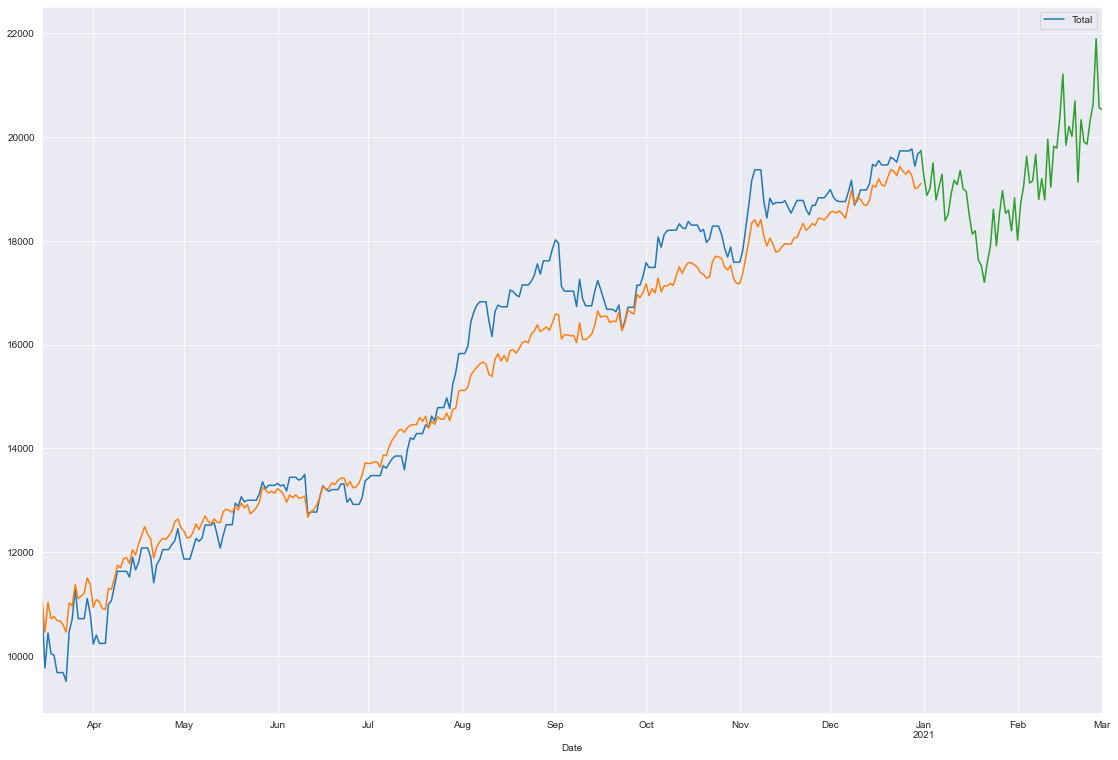

In [51]:
# Change frequency to day
tot_port_df = tot_port_df.asfreq('d')
tot_port_df.index

# Delete NaNs for nontrading days
tot_port_df = tot_port_df.fillna(method='ffill') # Fill in missing values using previous

tot_port_df

# Delete all unneeded columns
del_col = ["GNRC", "CPRT", "ODFL", "AMD", "PAYC", "CHTR", "EL", 
             "MKC", "PGR", "NEM", "CCI", "NFLX", "daily_return"]
for x in del_col:
    tot_port_df = tot_port_df.drop([x], axis=1)

# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()

# Figure out optimum lags for this data set
lags = ar_select_order(tot_port_df, maxlag=30)
print("Lags :", lags.ar_lags)

# Create our model using whole data set
model = AutoReg(tot_port_df['Total'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
print("Observations :", len(tot_port_df)) # 1459 observations

train_df = tot_port_df.iloc[0:1167] # First 80% 
test_df = tot_port_df.iloc[1167:] # Last 20%

# Define training model for 459 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(tot_port_df['Total'], 459).fit(cov_type="HC0")

# # Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # Orange
ax = prediction.plot(ax=ax) # Green

# Predict 100 days into the future
forecast = train_model.predict(start=end, end=end+60, dynamic=True)
ax = forecast.plot(ax=ax) # Green